# Cross-Encoder Fine-Tuning & Evaluation Notebook

This notebook outlines the end-to-end process for fine-tuning a Sentence-Transformers `CrossEncoder`.

In [25]:
!pip install sentence-transformers -q
!pip install pandas pyarrow -q
!pip uninstall -y huggingface_hub # Explicitly uninstall
!pip install huggingface_hub -q   # Install latest version

# Uninstall and reinstall was to fix dependency issue. Cell runs fine as is.

Found existing installation: huggingface-hub 0.31.4
Uninstalling huggingface-hub-0.31.4:
  Successfully uninstalled huggingface-hub-0.31.4


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Install & Import Dependencies

In [27]:
import os
import random
import pandas as pd
from sentence_transformers import CrossEncoder, InputExample
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score, roc_auc_score, average_precision_score

In [ ]:
import os
import boto3
from botocore.config import Config

def download_from_r2(object_name, local_path, bucket_name="bookdbio"):
    # ensure parent dir exists
    parent_dir = os.path.dirname(local_path)
    if parent_dir and not os.path.isdir(parent_dir):
        os.makedirs(parent_dir, exist_ok=True)

    s3 = boto3.client('s3',
        endpoint_url = f"temp",
        aws_access_key_id = 'temp',
        aws_secret_access_key = 'temp',
        config = Config(signature_version='s3v4')
   )

    try:
        s3.download_file(bucket_name, object_name, local_path)
        print(f"Successfully downloaded {object_name} to {local_path}")
    except Exception as e:
        print(f"Download failed for {object_name}: {e}")

In [ ]:
download_from_r2("temp", "temp")

Successfully downloaded data/training_pairs.parquet.zip to data/training_pairs.parquet.zip


## 2. Configuration

Alter the paths to where the training data is stored and where you want to store the model.

In [29]:
# Paths
data_path = '/content/drive/MyDrive/ML_Reranker/data/processed_training_pairs_parts_0_to_12.parquet'
output_model_dir = '/content/drive/MyDrive/ML_Reranker/models/reranker_finetuned_model'

Check to make sure the model output directory exists.

In [30]:
output_model_dir = '/content/drive/MyDrive/Colab_Book_Reranker/models/reranker_finetuned_model'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(output_model_dir):
    os.makedirs(output_model_dir)
    print(f"Directory created: {output_model_dir}")
else:
    print(f"Directory already exists: {output_model_dir}")

Directory already exists: /content/drive/MyDrive/Colab_Book_Reranker/models/reranker_finetuned_model


Setting random seed and model hyperparameters.

In [31]:
random_seed = 42
# Reproducibility
random.seed(random_seed)

In [32]:
epochs = 3
batch_size = 48
learning_rate = 2e-5

## 3. Load & Split Data

In [33]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 1) Load all pairs and drop book_id
df = pd.read_parquet(data_path)
df = df.drop('book_id', axis=1)

# 2) Get unique users
users = df['user_id'].unique()

# 3) First split: 80% train, 20% temp (val+test)
train_users, temp_users = train_test_split(
    users,
    test_size=0.2,
    random_state=random_seed
)

# 4) Second split: half of temp → val (10%), half → test (10%)
val_users, test_users = train_test_split(
    temp_users,
    test_size=0.5,
    random_state=random_seed
)

# 5) Build DataFrames
train_df = df[df['user_id'].isin(train_users)].reset_index(drop=True)
val_df   = df[df['user_id'].isin(val_users)].reset_index(drop=True)
test_df  = df[df['user_id'].isin(test_users)].reset_index(drop=True)

print(f"Train pairs: {len(train_df)}, Val pairs: {len(val_df)}, Test pairs: {len(test_df)}")

Train pairs: 222360, Val pairs: 27792, Test pairs: 27804


In [34]:
train_df.head()

,user_id,user_ctx,book_text,label
0,001af7947e217e17694c5a9c097afffb,Favorite books: Tao Te Ching by Lao Tzu and Gi...,Title: Down and Out in Paris and London | Genr...,1
1,001af7947e217e17694c5a9c097afffb,Favorite books: Tao Te Ching by Lao Tzu and Gi...,Title: The Virgin Suicides | Genres: coming-of...,0
2,001af7947e217e17694c5a9c097afffb,Favorite books: Tao Te Ching by Lao Tzu and Gi...,"Title: Seducing Cinderella (Fighting for Love,...",0
3,001af7947e217e17694c5a9c097afffb,Favorite books: Tao Te Ching by Lao Tzu and Gi...,Title: Highlander Untamed (MacLeods of Skye Tr...,0
4,001af7947e217e17694c5a9c097afffb,Favorite books: Tao Te Ching by Lao Tzu and Gi...,Title: A Woman in Berlin: Eight Weeks in the C...,1


## 4. Prepare InputExamples & DataLoaders

In [35]:
# Convert to InputExample
train_examples = [
    InputExample(texts=[row.user_ctx, row.book_text], label=float(row.label))
    for row in train_df.itertuples()
]

val_examples = [
    InputExample(texts=[row.user_ctx, row.book_text], label=float(row.label))
    for row in val_df.itertuples()
]

test_examples = [
    InputExample(texts=[row.user_ctx, row.book_text], label=float(row.label))
    for row in test_df.itertuples()
]

# DataLoaders
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
val_dataloader   = DataLoader(val_examples, shuffle=False, batch_size=batch_size)
test_dataloader  = DataLoader(test_examples, shuffle=False, batch_size=batch_size)


## 5. Baseline Pre Fine Tuning

In [44]:
# --- Baseline Model: Pre-trained CrossEncoder (No Fine-Tuning) ---
from sentence_transformers import CrossEncoder
from sklearn.metrics import roc_auc_score, average_precision_score, ndcg_score
import pandas as pd
import numpy as np

print("\n--- Starting Baseline Model: Pre-trained CrossEncoder ---")

# Initialize metric variables for baseline
baseline_global_roc_auc = None
baseline_global_ap = None
baseline_map = None
baseline_ndcg_3 = None
baseline_ndcg_5 = None
baseline_ndcg_10 = None

# --- Configuration ---
PRETRAINED_MODEL_NAME = 'cross-encoder/ms-marco-MiniLM-L-6-v2'
MAX_LENGTH_PRETRAINED = 384

if 'test_df' not in locals() or not isinstance(test_df, pd.DataFrame) or test_df.empty:
    print("Error: `test_df` is not defined, not a DataFrame, or is empty.")
    print("Please ensure `test_df` is created and populated from your data splitting cells before running this baseline.")
else:
    print(f"Using test_df with shape: {test_df.shape} for pre-trained baseline evaluation.")
    baseline_model_instance = None # Renamed to avoid conflict if 'baseline_model' is used elsewhere
    try:
        baseline_model_instance = CrossEncoder(
            PRETRAINED_MODEL_NAME,
            max_length=MAX_LENGTH_PRETRAINED
        )
        print(f"Successfully loaded pre-trained model: {PRETRAINED_MODEL_NAME}")
    except Exception as e:
        print(f"Error loading pre-trained model {PRETRAINED_MODEL_NAME}: {e}")

    if baseline_model_instance:
        if 'user_ctx' not in test_df.columns or 'book_text' not in test_df.columns:
            print("Error: `test_df` is missing 'user_ctx' or 'book_text' columns.")
        else:
            test_pairs_for_baseline = [[row.user_ctx, row.book_text] for row in test_df.itertuples()]

            if not test_pairs_for_baseline:
                print("Error: `test_pairs_for_baseline` list is empty. Cannot make predictions.")
            else:
                print("Making predictions with the pre-trained model...")
                baseline_scores_pred = []
                try:
                    baseline_scores_pred = baseline_model_instance.predict(test_pairs_for_baseline, show_progress_bar=True)

                    if 'label' not in test_df.columns:
                        print("Error: `test_df` is missing 'label' column for evaluation.")
                    else:
                        test_true_labels = test_df['label'].values

                        if len(baseline_scores_pred) == len(test_true_labels):
                            print(f"\n--- Pre-trained CrossEncoder Baseline Results ---")

                            baseline_global_roc_auc = roc_auc_score(test_true_labels, baseline_scores_pred)
                            baseline_global_ap = average_precision_score(test_true_labels, baseline_scores_pred)
                            print(f"Global ROC AUC: {baseline_global_roc_auc:.4f}")
                            print(f"Global Average Precision (across all items): {baseline_global_ap:.4f}")

                            user_ndcg_scores_at_3_bl = [] # Suffix _bl for baseline
                            user_ndcg_scores_at_5_bl = []
                            user_ndcg_scores_at_10_bl = []
                            user_ap_scores_bl = []

                            if 'user_id' in test_df.columns:
                                evaluation_df_baseline = pd.DataFrame({
                                    'user_id': test_df['user_id'],
                                    'label': test_true_labels,
                                    'score': baseline_scores_pred
                                })

                                for user_id_val in evaluation_df_baseline['user_id'].unique():
                                    user_data = evaluation_df_baseline[evaluation_df_baseline['user_id'] == user_id_val]

                                    if not user_data.empty and user_data['label'].sum() > 0:
                                        y_true_user_list = user_data['label'].values.tolist()
                                        y_score_user_list = user_data['score'].values.tolist()

                                        user_ap = average_precision_score(y_true_user_list, y_score_user_list)
                                        user_ap_scores_bl.append(user_ap)

                                        y_true_user_ndcg = [y_true_user_list]
                                        y_score_user_ndcg = [y_score_user_list]

                                        k3 = min(3, len(user_data))
                                        if k3 > 0:
                                            user_ndcg_3_val = ndcg_score(y_true_user_ndcg, y_score_user_ndcg, k=k3) # temp var
                                            user_ndcg_scores_at_3_bl.append(user_ndcg_3_val)

                                        k5 = min(5, len(user_data))
                                        if k5 > 0:
                                            user_ndcg_5_val = ndcg_score(y_true_user_ndcg, y_score_user_ndcg, k=k5) # temp var
                                            user_ndcg_scores_at_5_bl.append(user_ndcg_5_val)

                                        k10 = min(10, len(user_data))
                                        if k10 > 0:
                                             user_ndcg_10_val = ndcg_score(y_true_user_ndcg, y_score_user_ndcg, k=k10) # temp var
                                             user_ndcg_scores_at_10_bl.append(user_ndcg_10_val)

                                if user_ap_scores_bl:
                                    baseline_map = np.mean(user_ap_scores_bl)
                                    print(f"Mean Average Precision (MAP): {baseline_map:.4f}")
                                else:
                                    print("MAP could not be calculated (no valid user AP scores).")

                                if user_ndcg_scores_at_3_bl:
                                    baseline_ndcg_3 = np.mean(user_ndcg_scores_at_3_bl)
                                    print(f"Mean Per-User NDCG@3: {baseline_ndcg_3:.4f}")
                                else:
                                    print("Mean Per-User NDCG@3 could not be calculated.")

                                if user_ndcg_scores_at_5_bl:
                                    baseline_ndcg_5 = np.mean(user_ndcg_scores_at_5_bl)
                                    print(f"Mean Per-User NDCG@5: {baseline_ndcg_5:.4f}")
                                else:
                                    print("Mean Per-User NDCG@5 could not be calculated.")

                                if user_ndcg_scores_at_10_bl:
                                    baseline_ndcg_10 = np.mean(user_ndcg_scores_at_10_bl)
                                    print(f"Mean Per-User NDCG@10: {baseline_ndcg_10:.4f}")
                                else:
                                    print("Mean Per-User NDCG@10 could not be calculated.")
                            else:
                                print("Error: 'user_id' column not found in test_df. Cannot calculate per-user metrics.")
                        else:
                            print(f"Error: Mismatch in length between predicted scores ({len(baseline_scores_pred)}) and true labels ({len(test_true_labels)}). Evaluation skipped.")
                except Exception as e:
                    print(f"Error during prediction or evaluation with pre-trained model: {e}")

print("--- Baseline Model: Pre-trained CrossEncoder Finished ---")

# Verification print for baseline metrics
print("\n--- Saved Metrics for Baseline Model (for later comparison) ---")
print(f"baseline_global_roc_auc: {baseline_global_roc_auc}")
print(f"baseline_global_ap: {baseline_global_ap}")
print(f"baseline_map: {baseline_map}")
print(f"baseline_ndcg_3: {baseline_ndcg_3}")
print(f"baseline_ndcg_5: {baseline_ndcg_5}")
print(f"baseline_ndcg_10: {baseline_ndcg_10}")


--- Starting Baseline Model: Pre-trained CrossEncoder ---
Using test_df with shape: (27804, 4) for pre-trained baseline evaluation.
Successfully loaded pre-trained model: cross-encoder/ms-marco-MiniLM-L-6-v2
Making predictions with the pre-trained model...


Batches:   0%|          | 0/869 [00:00<?, ?it/s]


--- Pre-trained CrossEncoder Baseline Results ---
Global ROC AUC: 0.6067
Global Average Precision (across all items): 0.4237
Mean Average Precision (MAP): 0.6011
Mean Per-User NDCG@3: 0.4928
Mean Per-User NDCG@5: 0.5826
Mean Per-User NDCG@10: 0.7014
--- Baseline Model: Pre-trained CrossEncoder Finished ---

--- Saved Metrics for Baseline Model (for later comparison) ---
baseline_global_roc_auc: 0.6067280549310783
baseline_global_ap: 0.4236801542737625
baseline_map: 0.6011088130207681
baseline_ndcg_3: 0.49283395081225845
baseline_ndcg_5: 0.582558468226084
baseline_ndcg_10: 0.7014092689801137


## 5. Define Validation Evaluator

In [36]:
from sentence_transformers.cross_encoder.evaluation import CrossEncoderRerankingEvaluator

In [37]:
validation_samples = []
for user_id_val in val_df['user_id'].unique():
    user_data = val_df[val_df['user_id'] == user_id_val]

    if not user_data.empty:
        query_text = user_data['user_ctx'].iloc[0]

        positive_passages = list(user_data[user_data['label'] == 1]['book_text'])
        negative_passages = list(user_data[user_data['label'] == 0]['book_text'])

        # CrossEncoderRerankingEvaluator needs at least one positive passage for a query to be valid.
        if positive_passages and negative_passages:
          validation_samples.append({
              'query': query_text,
              'positive': positive_passages,
              'negative': negative_passages
               # Optional: 'query_id': str(user_id_val) # useful for debugging
              })
        elif positive_passages: # Case where there are only positives (less ideal for reranking eval but possible)
          validation_samples.append({
            'query': query_text,
            'positive': positive_passages,
            'negative': [] # Provide empty list of negatives
            })
        else:
            print(f"Warning: User {user_id_val} in val_df had no data, skipping for validation_samples.")

    if not validation_samples:
        print("Error: No valid validation_samples could be created for CrossEncoderRerankingEvaluator.")
        # Handle this case - perhaps set evaluator to None
        reranking_evaluator = None
else:
        print(f"Created {len(validation_samples)} validation samples for CrossEncoderRerankingEvaluator.")

Created 2316 validation samples for CrossEncoderRerankingEvaluator.


In [49]:
if validation_samples: # Only proceed if samples were created
  reranking_evaluator = CrossEncoderRerankingEvaluator(
  samples=validation_samples,
  name='val_rerank',
  at_k=10,
  batch_size=batch_size,
  show_progress_bar=True,
  write_csv=True
  )

else: # If no validation_samples
  reranking_evaluator = None


## 5. Instantiate & Fine-Tune CrossEncoder

cross-encoder/ms-marco-MiniLM-L-6-v2 is a 6-layer MiniLM distilled into a cross-encoder architecture and pretrained on the MS MARCO passage ranking task. It takes a paired input (e.g. user context + book text) and produces a single relevance score via full token-level attention.

Justification
	•	Ranking-Tuned Pretraining
Its MS MARCO heritage means it already knows how to judge fine-grained relevance patterns—crucial for matching nuanced book descriptions to user tastes.
	•	Speed-Quality Sweet Spot
At ~60 MB and with inference under 15 ms per candidate, it delivers ~90–95 % of full BERT-base accuracy, keeping end-to-end latency low.
	•	Efficient Fine-Tuning
Requires only 2–3 epochs over ~150 K (user,book) pairs to adapt deeply to book-domain language, making rapid iteration feasible.
	•	Compact & Deployable
Its small footprint simplifies packaging, loading, and scaling in production environments with moderate memory and compute budgets.

In [39]:
# 1. Calculate the number of training steps per epoch
num_train_steps_per_epoch = len(train_dataloader)
print(f"Number of training steps per epoch: {num_train_steps_per_epoch}")

# 2. Calculate warmup steps
warmup_ratio = 0.10  # 10% for warmup
actual_warmup_steps = int(num_train_steps_per_epoch * warmup_ratio)
print(f"Calculated warmup steps (10% of one epoch): {actual_warmup_steps}")

# Ensure warmup_steps is not zero if num_train_steps_per_epoch is very small
if actual_warmup_steps == 0 and num_train_steps_per_epoch > 0:
    actual_warmup_steps = 1 # Ensure at least 1 step if training is happening
    print(f"Adjusted warmup steps to 1 as calculated value was 0.")




Number of training steps per epoch: 4633
Calculated warmup steps (10% of one epoch): 463


In [40]:
from sentence_transformers import CrossEncoder
model = CrossEncoder(
    'cross-encoder/ms-marco-MiniLM-L-6-v2',
    num_labels=1,
    max_length=384,
)

model.fit(
    train_dataloader=train_dataloader,
    evaluator=reranking_evaluator,
    epochs=epochs, # e.g., 3
    optimizer_params={'lr': learning_rate}, # e.g., 2e-5
    scheduler='WarmupLinear',
    warmup_steps=actual_warmup_steps,
    evaluation_steps=num_train_steps_per_epoch,
    output_path=output_model_dir,
    save_best_model=True,
    use_amp=True,
    show_progress_bar=True,
)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Token indices sequence length is longer than the specified maximum sequence length for this model (408 > 384). Running this sequence through the model will result in indexing errors


Step,Training Loss,Validation Loss,Val Rerank Map,Val Rerank Mrr@10,Val Rerank Ndcg@10
4633,0.405000,No log,0.797673,0.929848,0.873533
9266,0.352900,No log,0.809594,0.936482,0.882994
13899,0.326700,No log,0.807672,0.933336,0.881431



--- Plotting CrossEncoder Validation Performance ---
Successfully loaded evaluation results from: /content/drive/MyDrive/Colab_Book_Reranker/models/reranker_finetuned_model/eval/CrossEncoderRerankingEvaluator_val_rerank_results_@10.csv
Columns in evaluation CSV: ['epoch', 'steps', 'MAP', 'MRR@10', 'NDCG@10']
Original data head:
    epoch  steps       MAP    MRR@10   NDCG@10
0    1.0   4633  0.796698  0.929016  0.872551
1    2.0   9266  0.809297  0.931495  0.881555
2    3.0  13899  0.810387  0.934761  0.882384
3    1.0   4633  0.797673  0.929848  0.873533
4    2.0   9266  0.809594  0.936482  0.882994
5    3.0  13899  0.807672  0.933336  0.881431
Cleaned data for plotting (first 6 rows after de-duping by steps and keeping best score):
    epoch  steps       MAP    MRR@10   NDCG@10
0    1.0   4633  0.797673  0.929848  0.873533
1    2.0   9266  0.809594  0.936482  0.882994
2    3.0  13899  0.810387  0.934761  0.882384
Validation plot saved to: /content/drive/MyDrive/Colab_Book_Reranker/mo

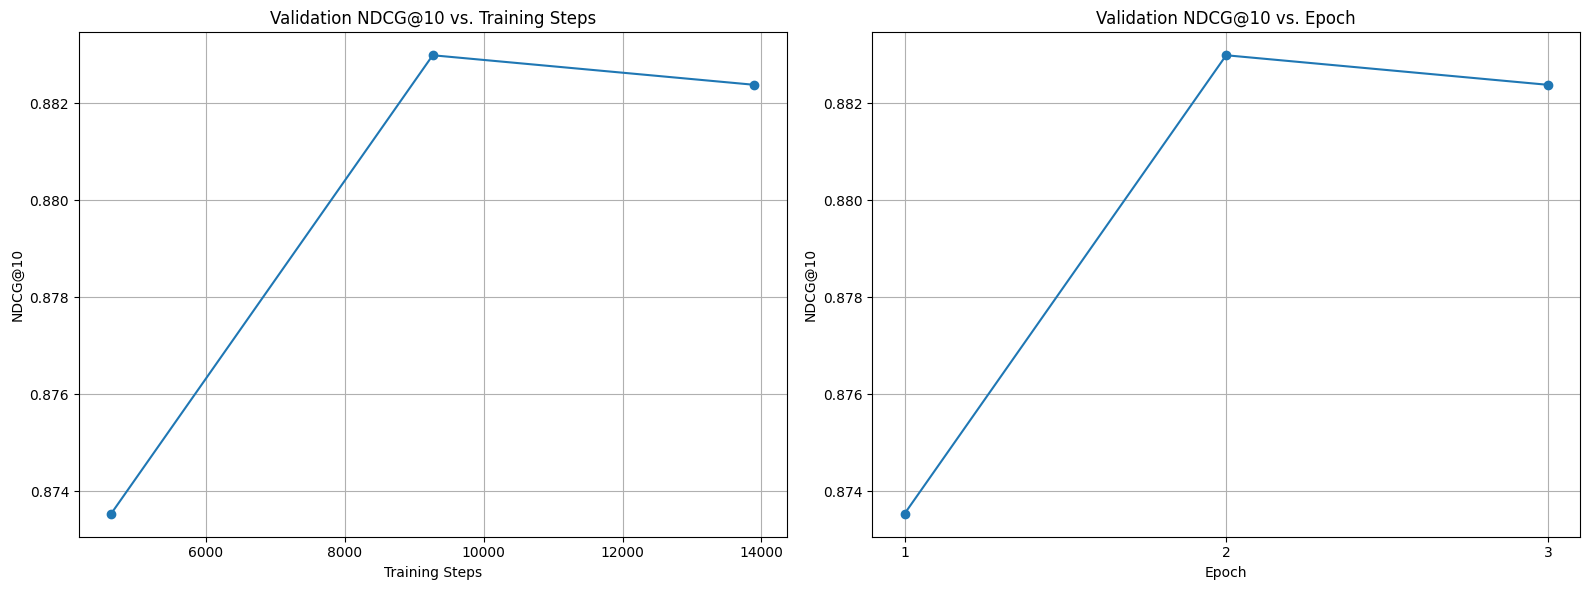

In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Plotting CrossEncoder Validation Performance ---
print("\n--- Plotting CrossEncoder Validation Performance ---")

# This should be the same as the 'output_path' you gave to model.fit()
# Ensure output_model_dir is defined correctly from your training setup
# Example: output_model_dir = '/content/drive/MyDrive/Colab_Book_Reranker/models/reranker_finetuned_model'
if 'output_model_dir' not in locals():
    print("Error: 'output_model_dir' is not defined. Please set it to your model's output directory.")
    # exit() # Or handle as appropriate
else:
    output_model_dir_from_training = output_model_dir

    # This MUST match the 'name' you gave to your CrossEncoderRerankingEvaluator instance
    evaluator_name_assumed = 'val_rerank'

    # Construct the filename based on the image you provided
    # The "@10" seems to be part of how your file was named.
    # The class name "CrossEncoderRerankingEvaluator" is also part of it.
    eval_filename = f"CrossEncoderRerankingEvaluator_{evaluator_name_assumed}_results_@10.csv"

    # Path where the file is located (based on your previous successful load message)
    # It seems to be in an 'eval' subdirectory.
    eval_filepath = os.path.join(output_model_dir_from_training, "eval", eval_filename)

    # The primary score column we want to plot
    score_column_to_plot = 'NDCG@10'

    try:
        if not os.path.exists(eval_filepath):
            # Fallback if the exact path from the image isn't found, try the more standard SBERT name
            standard_sbert_eval_filename = f"evaluation_{evaluator_name_assumed}_results.csv"
            eval_filepath_standard = os.path.join(output_model_dir_from_training, "eval", standard_sbert_eval_filename)
            if os.path.exists(eval_filepath_standard):
                eval_filepath = eval_filepath_standard
                print(f"Found file using standard SBERT naming: {eval_filepath}")
            else:
                 raise FileNotFoundError(f"Evaluation file not found at primary path {eval_filepath} or standard SBERT path {eval_filepath_standard}")


        eval_results_df = pd.read_csv(eval_filepath)
        print(f"Successfully loaded evaluation results from: {eval_filepath}")
        print("Columns in evaluation CSV:", eval_results_df.columns.tolist())
        print("Original data head:\n", eval_results_df.head(6))


        # --- Data Cleaning/Preparation for Plotting ---
        # Handle potential duplicate step/epoch entries:
        # Keep the entry with the highest 'score_column_to_plot' for each 'steps' value.
        # This also helps if there were restarts or multiple runs saved to the same file.
        # First sort by score descending, so when we drop duplicates, we keep the best one.
        eval_results_df = eval_results_df.sort_values(by=['steps', score_column_to_plot], ascending=[True, False])
        eval_results_df = eval_results_df.drop_duplicates(subset=['steps'], keep='first')

        # Also, ensure it's sorted by steps for the step-wise plot
        eval_results_df = eval_results_df.sort_values(by='steps').reset_index(drop=True)
        print("Cleaned data for plotting (first 6 rows after de-duping by steps and keeping best score):\n", eval_results_df.head(6))


        # Verify necessary columns are present after cleaning
        required_columns_for_plot = ['epoch', 'steps', score_column_to_plot]
        if not all(col in eval_results_df.columns for col in required_columns_for_plot):
            missing = [col for col in required_columns_for_plot if col not in eval_results_df.columns]
            print(f"Error: Required columns for plotting {missing} not found in {eval_filepath} after cleaning. Cannot plot.")
        elif eval_results_df.empty:
            print(f"Error: DataFrame is empty after cleaning operations. Cannot plot.")
        else:
            plt.figure(figsize=(16, 6)) # Made figure slightly wider

            # Plot score vs steps
            plt.subplot(1, 2, 1)
            plt.plot(eval_results_df['steps'], eval_results_df[score_column_to_plot], marker='o', linestyle='-')
            plt.title(f'Validation {score_column_to_plot} vs. Training Steps')
            plt.xlabel('Training Steps')
            plt.ylabel(score_column_to_plot)
            plt.grid(True)

            # Plot score vs epoch
            plt.subplot(1, 2, 2)
            # For the epoch plot, we want one distinct point per epoch.
            # Take the data point corresponding to the highest step count for each epoch.
            if 'epoch' in eval_results_df.columns and not eval_results_df.empty:
                # After de-duping by 'steps', if 'evaluation_steps' was set to once per epoch,
                # each 'steps' value should uniquely map to an epoch.
                # We can group by epoch and take the row with the max step (which should be the only step for that epoch now).
                epoch_end_evals = eval_results_df.loc[eval_results_df.groupby('epoch')['steps'].idxmax()]
                # Ensure it's sorted by epoch for plotting
                epoch_end_evals = epoch_end_evals.sort_values(by='epoch')
            else:
                epoch_end_evals = pd.DataFrame(columns=eval_results_df.columns)

            if not epoch_end_evals.empty:
                plt.plot(epoch_end_evals['epoch'], epoch_end_evals[score_column_to_plot], marker='o', linestyle='-')
                # Ensure x-ticks are set correctly for epochs that have data
                plt.xticks(epoch_end_evals['epoch'].unique().astype(float)) # Use .astype(float) if epoch is float like 1.0
            else:
                print("No data available for epoch plot after grouping.")

            plt.title(f'Validation {score_column_to_plot} vs. Epoch')
            plt.xlabel('Epoch')
            plt.ylabel(score_column_to_plot)
            plt.grid(True)

            plt.tight_layout()

            # Save the plot
            plot_save_filename = f"{evaluator_name_assumed}_{score_column_to_plot.replace('@','_at_')}_performance_plot.png"
            plot_save_path = os.path.join(output_model_dir_from_training, plot_save_filename)
            plt.savefig(plot_save_path)
            print(f"Validation plot saved to: {plot_save_path}")
            plt.show()

    except FileNotFoundError:
        print(f"Evaluation results file not found. Main attempted path: {eval_filepath}")
        print("Plotting skipped. Please ensure:")
        print(f"  1. `output_model_dir` ('{output_model_dir_from_training}') is correctly set.")
        print(f"  2. The evaluator name used ('{evaluator_name_assumed}') matches the one in training.")
        print(f"  3. Training completed at least one evaluation step and saved the results CSV.")
        print(f"  4. The CSV file named similar to '{eval_filename}' exists, likely in an 'eval' subdirectory.")
    except Exception as e:
        print(f"An error occurred during plotting: {e}")
        import traceback
        traceback.print_exc()


## 6. Evaluation on Test Set

In [42]:
from sklearn.metrics import roc_auc_score, average_precision_score, ndcg_score
import pandas as pd
import numpy as np

print("\n--- Evaluating Fine-Tuned CrossEncoder Model on Test Set ---")

# Initialize metric variables to None or a default (e.g., 0.0) in case evaluation fails
finetuned_global_roc_auc = None
finetuned_global_ap = None
finetuned_map = None
finetuned_ndcg_3 = None
finetuned_ndcg_5 = None
finetuned_ndcg_10 = None

if 'test_df' not in locals() or not isinstance(test_df, pd.DataFrame) or test_df.empty:
    print("Error: `test_df` is not defined, not a DataFrame, or is empty.")
    print("Please ensure `test_df` is available for final model evaluation.")
else:
    if 'user_ctx' not in test_df.columns or 'book_text' not in test_df.columns or 'label' not in test_df.columns:
        print("Error: `test_df` is missing one or more required columns: 'user_ctx', 'book_text', 'label'.")
    else:
        # 1. Prepare test pairs for prediction
        test_pairs_for_model = [[row.user_ctx, row.book_text] for row in test_df.itertuples()]

        if not test_pairs_for_model:
            print("Error: `test_pairs_for_model` list is empty. Cannot make predictions.")
        else:
            print("Making predictions with the fine-tuned model...")
            # 2. Get Predictions from the fine-tuned model
            # Make sure your 'model' variable refers to the trained model instance
            try:
                model_scores = model.predict(test_pairs_for_model, show_progress_bar=True)
                true_labels = test_df['label'].values

                if len(model_scores) == len(true_labels):
                    print(f"\n--- Fine-Tuned Model Test Set Results ---")

                    # 3. Compute and Store Global Metrics
                    finetuned_global_roc_auc = roc_auc_score(true_labels, model_scores)
                    finetuned_global_ap = average_precision_score(true_labels, model_scores)
                    print(f"Global ROC AUC: {finetuned_global_roc_auc:.4f}")
                    print(f"Global Average Precision (across all items): {finetuned_global_ap:.4f}")

                    # 4. Compute and Store Per-User Metrics (MAP, NDCG@3, NDCG@5, NDCG@10)
                    user_ap_scores_ft = []
                    user_ndcg_scores_at_3_ft = []
                    user_ndcg_scores_at_5_ft = []
                    user_ndcg_scores_at_10_ft = []

                    if 'user_id' in test_df.columns:
                        evaluation_df_ft = pd.DataFrame({
                            'user_id': test_df['user_id'],
                            'label': true_labels,
                            'score': model_scores
                        })

                        for user_id_val in evaluation_df_ft['user_id'].unique():
                            user_data = evaluation_df_ft[evaluation_df_ft['user_id'] == user_id_val]

                            if not user_data.empty and user_data['label'].sum() > 0:
                                y_true_user_list = user_data['label'].values.tolist()
                                y_score_user_list = user_data['score'].values.tolist()

                                user_ap = average_precision_score(y_true_user_list, y_score_user_list)
                                user_ap_scores_ft.append(user_ap)

                                y_true_user_ndcg = [y_true_user_list]
                                y_score_user_ndcg = [y_score_user_list]

                                k3 = min(3, len(user_data))
                                if k3 > 0:
                                    user_ndcg_3 = ndcg_score(y_true_user_ndcg, y_score_user_ndcg, k=k3)
                                    user_ndcg_scores_at_3_ft.append(user_ndcg_3)

                                k5 = min(5, len(user_data))
                                if k5 > 0:
                                    user_ndcg_5 = ndcg_score(y_true_user_ndcg, y_score_user_ndcg, k=k5)
                                    user_ndcg_scores_at_5_ft.append(user_ndcg_5)

                                k10 = min(10, len(user_data))
                                if k10 > 0:
                                    user_ndcg_10 = ndcg_score(y_true_user_ndcg, y_score_user_ndcg, k=k10)
                                    user_ndcg_scores_at_10_ft.append(user_ndcg_10)

                        if user_ap_scores_ft:
                            finetuned_map = np.mean(user_ap_scores_ft)
                            print(f"Mean Average Precision (MAP): {finetuned_map:.4f}")
                        else:
                            print("MAP could not be calculated.")

                        if user_ndcg_scores_at_3_ft:
                            finetuned_ndcg_3 = np.mean(user_ndcg_scores_at_3_ft)
                            print(f"Mean Per-User NDCG@3: {finetuned_ndcg_3:.4f}")
                        else:
                            print("Mean Per-User NDCG@3 could not be calculated.")

                        if user_ndcg_scores_at_5_ft:
                            finetuned_ndcg_5 = np.mean(user_ndcg_scores_at_5_ft)
                            print(f"Mean Per-User NDCG@5: {finetuned_ndcg_5:.4f}")
                        else:
                            print("Mean Per-User NDCG@5 could not be calculated.")

                        if user_ndcg_scores_at_10_ft:
                            finetuned_ndcg_10 = np.mean(user_ndcg_scores_at_10_ft)
                            print(f"Mean Per-User NDCG@10: {finetuned_ndcg_10:.4f}")
                        else:
                            print("Mean Per-User NDCG@10 could not be calculated.")
                    else:
                        print("Error: 'user_id' column not found in test_df. Cannot calculate per-user metrics.")
                else:
                    print(f"Error: Mismatch in length between model_scores ({len(model_scores)}) and true_labels ({len(true_labels)}). Evaluation skipped.")
            except Exception as e:
                print(f"Error during prediction or evaluation with the fine-tuned model: {e}")

print("--- Fine-Tuned Model Evaluation Finished ---")

# You can now verify the variables:
print("\n--- Saved Metrics for Fine-Tuned Model (for later comparison) ---")
print(f"finetuned_global_roc_auc: {finetuned_global_roc_auc}")
print(f"finetuned_global_ap: {finetuned_global_ap}")
print(f"finetuned_map: {finetuned_map}")
print(f"finetuned_ndcg_3: {finetuned_ndcg_3}")
print(f"finetuned_ndcg_5: {finetuned_ndcg_5}")
print(f"finetuned_ndcg_10: {finetuned_ndcg_10}")


--- Evaluating Fine-Tuned CrossEncoder Model on Test Set ---
Making predictions with the fine-tuned model...


Batches:   0%|          | 0/869 [00:00<?, ?it/s]


--- Fine-Tuned Model Test Set Results ---
Global ROC AUC: 0.8478
Global Average Precision (across all items): 0.7084
Mean Average Precision (MAP): 0.8087
Mean Per-User NDCG@3: 0.7478
Mean Per-User NDCG@5: 0.7992
Mean Per-User NDCG@10: 0.8826
--- Fine-Tuned Model Evaluation Finished ---

--- Saved Metrics for Fine-Tuned Model (for later comparison) ---
finetuned_global_roc_auc: 0.8477630504805191
finetuned_global_ap: 0.7083979539874459
finetuned_map: 0.8086608112072073
finetuned_ndcg_3: 0.7478223409875145
finetuned_ndcg_5: 0.7991898079229435
finetuned_ndcg_10: 0.8825917383416094


## 7. Comparison

--- Model Performance Comparison ---
        Metric  Baseline  Fine-Tuned  Improvement  Improvement (%)
Global ROC AUC  0.606728    0.847763     0.241035            39.73
     Global AP  0.423680    0.708398     0.284718            67.20
           MAP  0.601109    0.808661     0.207552            34.53
        NDCG@3  0.492834    0.747822     0.254988            51.74
        NDCG@5  0.582558    0.799190     0.216631            37.19
       NDCG@10  0.701409    0.882592     0.181182            25.83




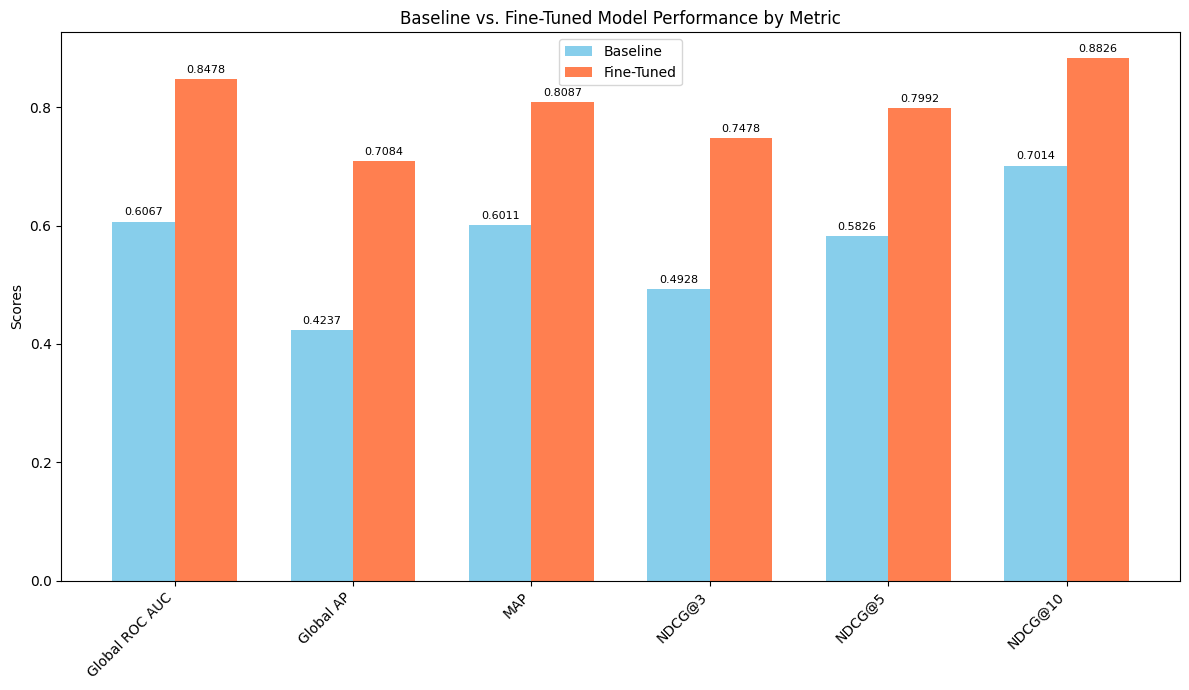

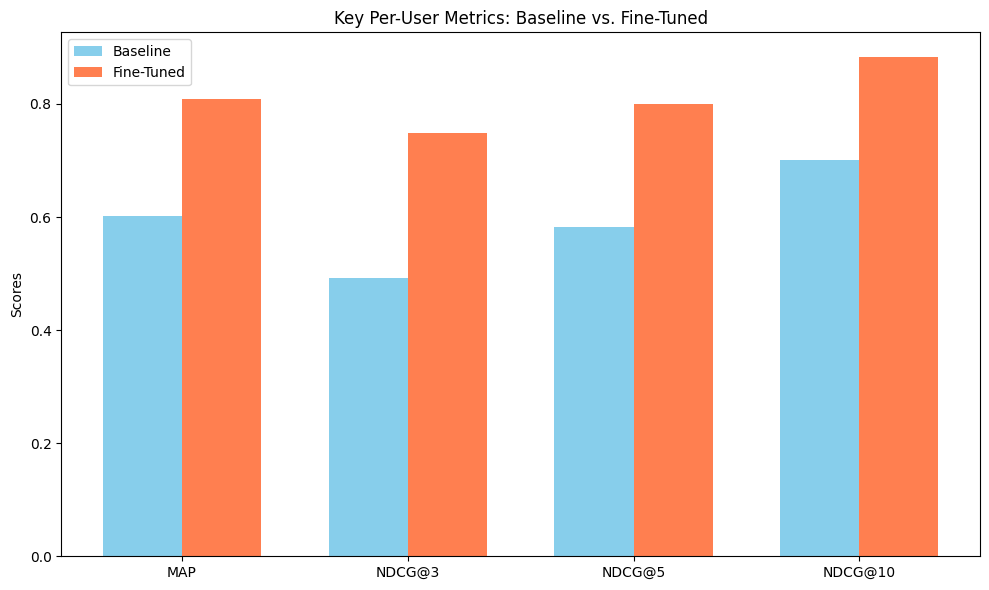

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Metrics from Baseline Model ---
baseline_metrics = {
    'Global ROC AUC': baseline_global_roc_auc,
    'Global AP': baseline_global_ap,
    'MAP': baseline_map,
    'NDCG@3': baseline_ndcg_3,
    'NDCG@5': baseline_ndcg_5,
    'NDCG@10': baseline_ndcg_10
}

# --- Metrics from Fine-Tuned Model ---
finetuned_metrics = {
    'Global ROC AUC': finetuned_global_roc_auc,
    'Global AP': finetuned_global_ap,
    'MAP': finetuned_map,
    'NDCG@3': finetuned_ndcg_3,
    'NDCG@5': finetuned_ndcg_5,
    'NDCG@10': finetuned_ndcg_10
}

# 1. Create a Comparison Table
metrics_data = {
    'Metric': list(baseline_metrics.keys()),
    'Baseline': list(baseline_metrics.values()),
    'Fine-Tuned': list(finetuned_metrics.values())
}
comparison_df = pd.DataFrame(metrics_data)
comparison_df['Improvement'] = comparison_df['Fine-Tuned'] - comparison_df['Baseline']
comparison_df['Improvement (%)'] = (comparison_df['Improvement'] / comparison_df['Baseline']) * 100
comparison_df['Improvement (%)'] = comparison_df['Improvement (%)'].round(2)

print("--- Model Performance Comparison ---")
print(comparison_df.to_string(index=False))
print("\n" + "="*50 + "\n")


# 2. Generate Bar Charts for Visual Comparison
metric_names = list(baseline_metrics.keys())
baseline_values = list(baseline_metrics.values())
finetuned_values = list(finetuned_metrics.values())

num_metrics = len(metric_names)
bar_width = 0.35
index = np.arange(num_metrics)

fig, ax = plt.subplots(figsize=(12, 7))

rects1 = ax.bar(index - bar_width/2, baseline_values, bar_width, label='Baseline', color='skyblue')
rects2 = ax.bar(index + bar_width/2, finetuned_values, bar_width, label='Fine-Tuned', color='coral')

ax.set_ylabel('Scores')
ax.set_title('Baseline vs. Fine-Tuned Model Performance by Metric')
ax.set_xticks(index)
ax.set_xticklabels(metric_names, rotation=45, ha="right")
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

key_per_user_metrics = ['MAP', 'NDCG@3', 'NDCG@5', 'NDCG@10']
key_baseline_values = [baseline_metrics[m] for m in key_per_user_metrics]
key_finetuned_values = [finetuned_metrics[m] for m in key_per_user_metrics]

num_key_metrics = len(key_per_user_metrics)
index_key = np.arange(num_key_metrics)

fig_key, ax_key = plt.subplots(figsize=(10, 6))
rects1_key = ax_key.bar(index_key - bar_width/2, key_baseline_values, bar_width, label='Baseline', color='skyblue')
rects2_key = ax_key.bar(index_key + bar_width/2, key_finetuned_values, bar_width, label='Fine-Tuned', color='coral')

ax_key.set_ylabel('Scores')
ax_key.set_title('Key Per-User Metrics: Baseline vs. Fine-Tuned')
ax_key.set_xticks(index_key)
ax_key.set_xticklabels(key_per_user_metrics)
ax_key.legend()

autolabel(rects1_key)
autolabel(rects2_key)

fig_key.tight_layout()
plt.show()


## 7. Save & Load Model

In [48]:
from google.colab import files
import os

# 1. Define the path to your model folder on Google Drive
gdrive_model_folder_path = '/content/drive/MyDrive/Colab_Book_Reranker/models/reranker_finetuned_model'

# 2. Define the name for the zip file you want to create (it will be saved in Colab's root /content/ directory)
local_zip_file_name = 'reranker_finetuned_model.zip'
local_zip_file_path = f'/content/{local_zip_file_name}' # Full path for the local zip file

# 3. Check if the Google Drive folder exists before trying to zip
if os.path.exists(gdrive_model_folder_path):
    print(f"Zipping folder: {gdrive_model_folder_path}")

    parent_dir_of_model = os.path.dirname(gdrive_model_folder_path)
    model_folder_name = os.path.basename(gdrive_model_folder_path)

    # Construct the zip command:
    # 1. cd into the parent directory of the model folder.
    # 2. Zip the model folder from there. The paths in the zip will be relative to this parent directory.
    #    The zip file itself will be created in the /content/ directory of Colab.
    zip_command = f"cd '{parent_dir_of_model}' && zip -r '{local_zip_file_path}' '{model_folder_name}'"

    print(f"Executing command: {zip_command}")
    # Execute the zip command
    zip_process_result = get_ipython().system_raw(zip_command) # Use system_raw to see output/errors

    # Check if the zip file was created successfully in Colab's local storage
    if os.path.exists(local_zip_file_path):
        print(f"Successfully created zip file: {local_zip_file_path}")
        # 4. Download the zip file
        print(f"Starting download of {local_zip_file_name}...")
        files.download(local_zip_file_path)
        print(f"If the download doesn't start automatically, check your browser's download permissions for this site.")
    else:
        print(f"Error: Zip file {local_zip_file_path} was not created.")
        if zip_process_result: # If system_raw captured something
             print(f"Zip command output/error: {zip_process_result}")
        else:
             print("Check the command execution details if any errors were printed above by the shell.")

else:
    print(f"Error: Model folder not found at {gdrive_model_folder_path}. Cannot create zip file.")

Zipping folder: /content/drive/MyDrive/Colab_Book_Reranker/models/reranker_finetuned_model
Executing command: cd '/content/drive/MyDrive/Colab_Book_Reranker/models' && zip -r '/content/reranker_finetuned_model.zip' 'reranker_finetuned_model'
Successfully created zip file: /content/reranker_finetuned_model.zip
Starting download of reranker_finetuned_model.zip...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

If the download doesn't start automatically, check your browser's download permissions for this site.


In [46]:
# Model is already saved during fit
# To load:
from sentence_transformers import CrossEncoder
loaded_model = CrossEncoder(output_model_dir)


## 8. Inference Example

In [ ]:
# Given a single user and its candidates
user_ctx = "Favorite books: ..."  # fetched or precomputed
candidate_texts = ["Title: ... Description: ...", ...]
pairs = [[user_ctx, txt] for txt in candidate_texts]
scores = loaded_model.predict(pairs)

# Rerank
candidates = ['book1', 'book2', ...]
ranked = sorted(zip(candidates, scores), key=lambda x: x[1], reverse=True)
print(ranked[:10])